In [336]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(font_scale=1)

## Singleton Estimation

We want to estimate the number of singletons that we can expect to have for skeleton tree reconstruction

<b> Variables to Consider:</b>

- num_targets - number of potential target sites 
- mut_rate - mutation rate per target site
- edit_distribution - distribution over potential edits per target site

<hr>

<b> Simulation Formulation </b>

We begin each simulation with one cell, representing the fertilised egg, that has all its targets in an unmutated state. The initial cell then undergoes a series of cell divisions (d), growing into a population of N cells, where $N=2^d$. Following each cell division, each unmutated target can mutate (with a given probability μd) to one of several possible mutated states. Once a target is mutated, it can no longer change, either to revert to the unmutated state or to transit to a new state.


<b> Useful References </b>

<sub> [1]https://elifesciences.org/articles/40292


</sub>

In [253]:
## How many cells does the real data end up with?
## Did this seed from one cell? 

import pickle
with open('/Users/sitarapersad/Downloads/d21_indel_distributions.p', 'rb') as f:
    indel_distributions = pickle.load(f)

slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

for li in [slow_guides, medium_guides, fast_guides]:
    for guide in li:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        distvals = np.array(sorted(list(dist.values()), reverse=True))
        distvals = distvals/distvals.sum()
        plt.figure()
        sns.barplot(np.arange(len(distvals)), distvals, linewidth=0)
        plt.title('Density over different edits for guide {0}'.format(guide))
        plt.show()
        plt.close()

# Estimate the mutation probability

# For a given site E_i[%] = E_{i-1}[%] + p(1-E_{i-1}[%])
# E_i = 1-q^i, where q = 1-p 
# Sanity check: 
# E_0 = 1-(1-p)^0 = 0 
# E_1 = 1-(1-p) = p 

# We can choose to use a combination of varying speed guides 

# 4, 7, 14, 21 days -> 4 generations, 7 generations etc (24 hrs for cell cycle?)

# How many generations does 1 day correspond to?
# Slow guides:
slow = [0.09, 0.15, 0.29, 0.4]

# Medium guides
medium = [0.15, 0.35, 0.6, 0.75]

# Fast guides
fast = [0.75, 0.9, 0.95, 0.96]




In [265]:
gens = [4,7,14,21]
print('\nSlow')
p_avg = 0
for i, x in enumerate(slow):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nMedium')
p_avg = 0
for i, x in enumerate(medium):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nFast')
p_avg = 0
for i, x in enumerate(fast):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)    

""" 
Questions
1. tree or forest
2. are the rates based on isolating a clone or from a forest
3. yosef lab was a single tree?? no

try this instead: 
start with many roots (a forest)

reproduction rate varying / same ?vfr 

"""


Slow
0.02330188829047808
0.02294954933760507
0.02416678505263603
0.024031560532588148
Avg
0.02361244580332683

Medium
0.03981541059581217
0.05968505934696777
0.06335350204906998
0.0638822575463951
Avg
0.056684057384561254

Fast
0.2928932188134524
0.28031432699884795
0.19263617565013524
0.14211035031316765
Avg
0.22698851794390082


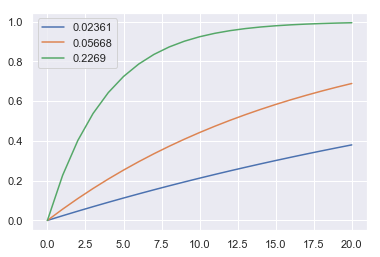

In [270]:
plt.figure()
for p in [0.02361, 0.05668, 0.2269]:
    q = 1-p
    plt.plot(np.arange(21), 1-q**np.arange(21), label=p)
plt.legend()
plt.show()
plt.close()

rate = {}
rate['slow'] = 0.02361
rate['medium'] = 0.05668
rate['fast'] = 0.2269

In [382]:
slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

ssm = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT','AATCCCTAGTAGATTAGCCT']
smm = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA']
ssf = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'CCTCCCGTAGTGTTGAGTCA']
smf = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CCTCCCGTAGTGTTGAGTCA']
sff = ['AGCTGCTTAGGGCGCAGCCT', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']
mmf = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TAATTCCGGACGAAATCTTG']
mff = ['AATCCCTAGTAGATTAGCCT', 'TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT']


results = {'Guides':[], 'Num_Distinct_Edits':[], 
           'Min_depths':[], 'Num_Mutations':[],
           'Recurring_Characters':[],  
           'Recurring_Characters_%':[],
           'Recurring_Mutations' : [],
           'Recurring_Mutations_%': []
          }
    
lists_of_guides = [slow_guides, ssm, smm, ssf, smf, sff, medium_guides, mmf, mff, fast_guides]
labels = ['sss','ssm','smm','ssf','smf','sff', 'mmm', 'mmf','mff', 'fff']
verbose = False
tree_depth = 20
num_runs = 10
n_subsample = 3

debug = True
if debug:
    lists_of_guides = lists_of_guides[:1]
    labels = labels[:1]
    tree_depth = 3
    num_runs = 1
    
for i, list_of_guides in enumerate(lists_of_guides):
    label = labels[i]
    print('Label:', label)
    # Each array has 3-6 targets, we insert ~10 arrays. This gives us 30-60 sites

    site_ix = 0
    target_distributions = {}
    speed = {}
    for guide in list_of_guides:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        distvals = np.array(sorted(list(dist.values()), reverse=True))
        distvals = distvals/distvals.sum()
        target_distributions[site_ix] = distvals
        if guide in slow_guides:
            speed[site_ix] = 'slow'
        elif guide in medium_guides:
            speed[site_ix] = 'medium'
        else:
            speed[site_ix] = 'fast'

        site_ix += 1

    num_targets = site_ix 
    print('num_targets', num_targets)
    num_arrays = 10

    num_edit_sites = num_targets * num_arrays

    import itertools
    targets = list(itertools.product(np.arange(num_arrays), np.arange(num_targets)))
    print('List of targets: ', targets)

    deletions = []
    mutation_probs = []
    for array, target in targets:
        deletions.append(target_distributions[target])
        mutation_probs.append(rate[speed[target]])
    
    deletions_weights = pd.DataFrame(deletions)
    deletions_weights = torch.DoubleTensor(deletions_weights.fillna(0.0).values)
    
    # Each edit site has a different mutation probability 
    mutation_probs= np.array(mutation_probs)

    

    num_edits = []
    min_depths = []
    num_recurring_chars = []
    proportion_recurring_chars = []
    num_recurring_muts = []
    proportion_recurring_muts = []
    num_mutations_list = []
    
    records = []
    
    
    for run in range(num_runs):

        # Simulating a tree: we start out with a single cell which is unmutated
        cell_recorder = np.zeros((1, num_edit_sites))
        min_depth = np.nan


        # TODO: Fix this reproduction probability
        reproduction_prob = 1.0 


        edits_occurred = set([])
        convergence = {}
        num_mutations = 0
        record = [cell_recorder]
        novel_edit_list = [] 
        for i in range(tree_depth):
            # One round of CRISPR may happen between this generation's division 
            # and the previous generation

            num_cells = cell_recorder.shape[0]

            print('{0} cell(s) at depth {1}'.format(num_cells, i))

            # TODO: Will each cell divide? And at what rate? This should be considered
            reproducting = np.random.random((num_cells, num_edit_sites)) <= reproduction_prob

            # For each target, mutate with a fixed probability
            # This probability empirically estimated from MSKCC data with 
            # the assumption of fixed reproduction time.

            # An edit occurs if 
            # (1) the probability drawn is sufficient and 
            mutating = np.random.random((num_cells, num_edit_sites)) <= mutation_probs

            # (2) the site is not already edited.
            not_edited = cell_recorder == 0 

            edit_here = mutating & not_edited
            
            num_mutations += edit_here.sum()
            
            novel_edits = edit_here
            if edit_here.sum() > 0:
                # For the cells and targets which are mutating, now draw a deletion 
                # from the distribution specific to that. Deletions are indexed starting at 1
                deletion_choice = 1 + torch.multinomial(torch.DoubleTensor(deletions_weights), num_cells, replacement=True).numpy().T
                deletion_choice[~edit_here] = 0
                novel_edits = deletion_choice 
                
                if verbose:
                    print('mutating')
                    print(mutating)
                    print('not edited')
                    print(not_edited)
                    print('edit_here')
                    print(edit_here)
                    print('deletion_ix per cell')
                    print(deletion_choice)

                    print('cell recorder before')
                    print(cell_recorder)


                

                sites, cells = np.where(deletion_choice !=0)
                
#                 print(sites, 'sites')
                site_edits = list(zip(sites, deletion_choice[(sites, cells)]))

                intersection = edits_occurred.intersection(site_edits)

                for edit in intersection:
                    if verbose:
                        print('{0} already occurred before {1}'.format(edit, i))
                    # If a sampled (target, deletion) has already occurred, 
                    # then note the tree depth before we have 'convergent' evolution
                    convergence[edit] = convergence.get(edit, []) + [i]
                    if np.isnan(min_depth):
                        min_depth = i

                # Update the list of (target, deletions) that have already occurred.
                edits_occurred = edits_occurred.union(site_edits)    


                cell_recorder += deletion_choice 
                if verbose:
                    print('after')
                    print(cell_recorder)
            
            record.append(cell_recorder)
            
            # New cell_recorder has double the entries after replication
            # TODO: Only allow some cells to replicate    
            cell_recorder = np.repeat(cell_recorder, 2, axis=0)
            
        num_cells = cell_recorder.shape[0]
        print('{0} cell(s) at depth {1}'.format(num_cells, tree_depth))

        num_edits.append(len(edits_occurred))
        num_mutations_list.append(num_mutations)
        min_depths.append(min_depth)
        num_recurring_chars.append(len(convergence))
        num_recurring_muts.append(sum([len(val) for val in convergence.values()]))
        proportion_recurring_chars.append(len(convergence)/max(1, len(edits_occurred)))
        proportion_recurring_muts.append(num_recurring_muts[-1]/max(1, num_mutations))
        
    
        records.append(record)
    
    # Subsample cells 
    subsampled_ix = np.random.choice(cell_recorder.shape[0], n_subsample, replace=False)
    subsampled = cell_recorder[subsampled_ix, :]
    
    # We only care about the ancestors of these subsampled cells
    
    
    # Summarise results for this combination of guides 
    results['Guides'] += [label]*num_runs
    results['Num_Distinct_Edits'] += num_edits
    results['Min_depths'] += min_depths
    results['Num_Mutations']
    results['Recurring_Characters'] += num_recurring_chars
    results['Recurring_Mutations'] += num_recurring_muts
    results['Recurring_Characters_%'] += 100*proportion_recurring_chars
    results['Recurring_Mutations_%'] += 100*proportion_recurring_muts


Label: sss
num_targets 3
List of targets:  [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (6, 2), (7, 0), (7, 1), (7, 2), (8, 0), (8, 1), (8, 2), (9, 0), (9, 1), (9, 2)]
1 cell(s) at depth 0
2 cell(s) at depth 1
4 cell(s) at depth 2
8 cell(s) at depth 3


In [383]:
subsampled_ix

array([6, 2, 1])

In [350]:
df = pd.DataFrame(results)
df.head()

# For a subsampled to 10,000 
# For a typical cell - how many mutations does it have that are recurrent

ValueError: arrays must all be same length

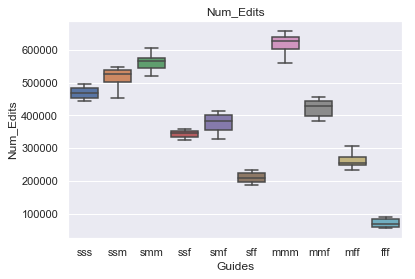

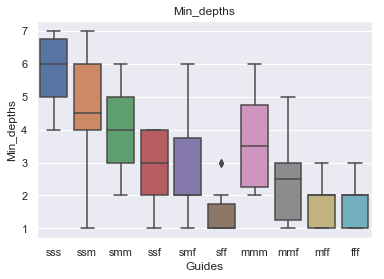

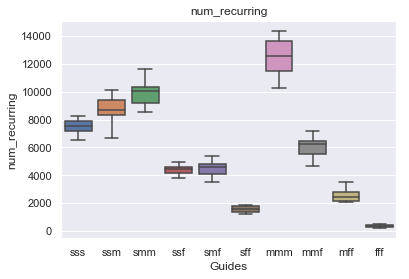

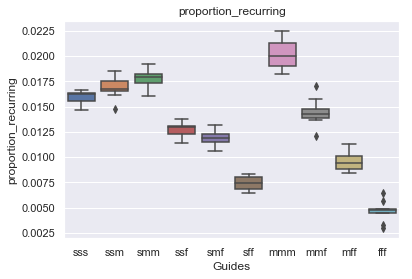

In [326]:
for y in ['Num_Edits', 'Min_depths', 'num_recurring', 'proportion_recurring']:
    plt.figure()
    ax = sns.boxplot(x='Guides', y=y, data=df) #, order=['PICASSO Iter final', 'PICASSO Iter 0', 'PICASSO Iter 1'])
    plt.title(y)
    plt.show()
    plt.close()
    


In [327]:
3 targets/ array
10 arrays

-> 30 sites 

# What fractions of the mutations are recurring



CHARACTER 
introduction of a character is a mutation





SyntaxError: invalid syntax (<ipython-input-327-994ec9de55b2>, line 1)

In [328]:
deletions_weights.shape

torch.Size([30, 347])

In [368]:
def lineage_to_index(ii):
    ii = str(ii)
    L = 2**len(ii)
    index = 0
    for i, entry in enumerate(list(ii)):
        index += L/(2**(i+1)) * int(entry) 
    return index 

lineage_to_index(111)

7.0

In [ ]:
000 001 010 011 100 101 110 111

00 01 10 11 